In [18]:
# ouvrir les packages
import plotly.graph_objects as go 
import pandas as pd
import numpy as np
import ssl
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.integrate import odeint

ssl._create_default_https_context = ssl._create_unverified_context

In [216]:
# ouvrir le fichier des données

df = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7', sep=';')
#df = pd.read_csv('donnees-hospitalieres-covid19-2020-08-05-19h00.csv', sep=';')
df.head(10)

dep  sexe        jour  hosp  rea  rad  dc
0  01     0  2020-03-18     2    0    1   0
1  01     1  2020-03-18     1    0    1   0
2  01     2  2020-03-18     1    0    0   0
3  02     0  2020-03-18    41   10   18  11
4  02     1  2020-03-18    19    4   11   6
5  02     2  2020-03-18    22    6    7   5
6  03     0  2020-03-18     4    0    1   0
7  03     1  2020-03-18     1    0    0   0
8  03     2  2020-03-18     3    0    1   0
9  04     0  2020-03-18     3    1    2   0

In [217]:
df = df.dropna()

### Nettoyage des données

In [218]:
df.index = df['jour'] # mettre en index les jours des pays
df = df.drop(['jour'], axis=1) # enlever la colonne jour dupliqué
df.head(10)

dep  sexe  hosp  rea  rad  dc
jour                                    
2020-03-18  01     0     2    0    1   0
2020-03-18  01     1     1    0    1   0
2020-03-18  01     2     1    0    0   0
2020-03-18  02     0    41   10   18  11
2020-03-18  02     1    19    4   11   6
2020-03-18  02     2    22    6    7   5
2020-03-18  03     0     4    0    1   0
2020-03-18  03     1     1    0    0   0
2020-03-18  03     2     3    0    1   0
2020-03-18  04     0     3    1    2   0

In [219]:
df_described = df.describe()
df_described.head(20)

sexe          hosp           rea           rad            dc
count  50904.000000  50904.000000  50904.000000  50904.000000  50904.000000
mean       1.000000     91.942185     13.201615    399.595336    105.065457
std        0.816505    204.131664     38.872163    687.962594    192.002222
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      6.000000      0.000000     55.000000     11.000000
50%        1.000000     24.000000      2.000000    144.000000     36.000000
75%        2.000000     80.000000      9.000000    398.000000     98.000000
max        2.000000   3281.000000    855.000000   6641.000000   1810.000000

In [21]:
df_dep_filtered = df.filter(['dep','jour','hosp','rea','rad','dc'])
df_dep_filtered.head(10)

dep  hosp  rea  rad  dc
jour                              
2020-03-18  01     2    0    1   0
2020-03-18  01     1    0    1   0
2020-03-18  01     1    0    0   0
2020-03-18  02    41   10   18  11
2020-03-18  02    19    4   11   6
2020-03-18  02    22    6    7   5
2020-03-18  03     4    0    1   0
2020-03-18  03     1    0    0   0
2020-03-18  03     3    0    1   0
2020-03-18  04     3    1    2   0

In [23]:
df_dep = df_dep_filtered.groupby('dep').sum()
df_dep.head(10)

hosp   rea     rad     dc
dep                            
01   25029  2220  109590  27635
02   46200  5602  268127  75662
03    6220  1423   51392  10519
04    3984   328   35498   3304
05    6721  1088   35352   4458
06   37446  5660  192281  49927
07   15036  2080  111278  28441
08    9355  1577   50821  15123
09    1357   436    9019    548
10   25796  1944  158967  36866

In [24]:
# Classer les departement par ordre de decroissance pour voir les departement les plus affecté 
df_sorted_by_dep = df_dep.sort_values(['dc','rea','rad','hosp'], ascending=False) 
df_sorted_by_dep.head(10)


hosp    rea      rad      dc
dep                                
75   388441  79484  1607392  487331
94   317492  33873  1046377  321840
92   343857  46546  1130977  294318
93   286688  32612   944804  274562
68   166258  16624   754254  236870
57   149949  18655   627837  231583
95   166343  16059   674325  195340
67   165951  24588   664390  183716
77   127203  23644   679818  181181
69   165956  25509   760933  177837

In [223]:
# Pie chart
fig = px.pie(df, values='dc', names='dep', title='Nombre de décès par département')
fig.show()

In [154]:
fig = px.line(df, x=df.index, y='hosp', color='dep')
fig.show()

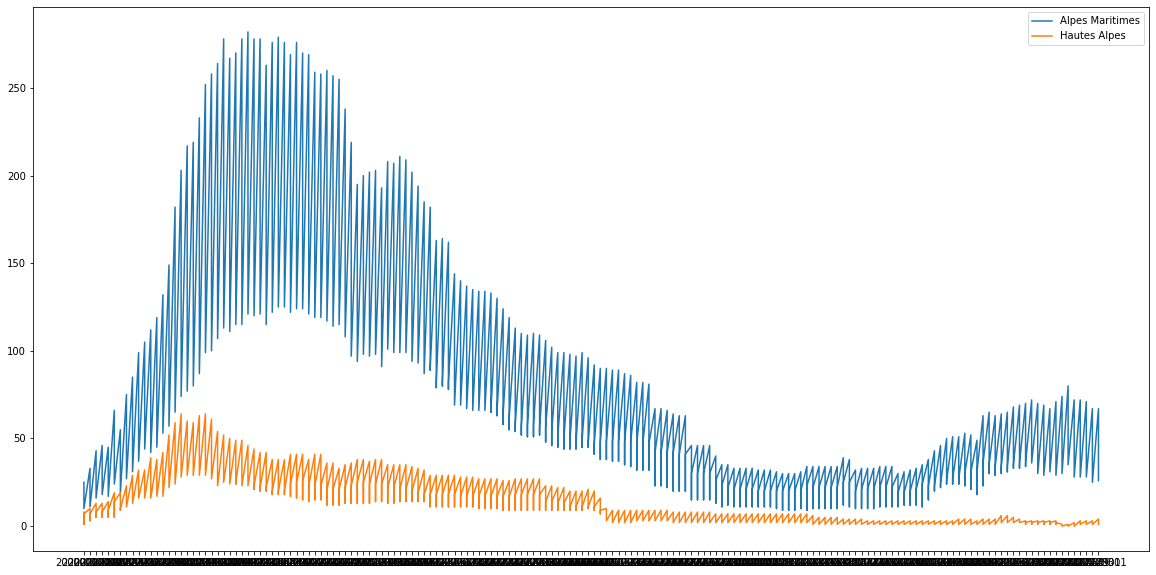

([<matplotlib.lines.Line2D at 0x276343a0400>],
 [<matplotlib.lines.Line2D at 0x27638eeda90>])

In [221]:
# fonction afficher une courbe par département 
def trace_by_dep (criteria,first_name, second_dep) : 
        
        dep1 = df.loc[df['dep'] == first_name] 
        dep2 = df.loc[df['dep'] == second_dep] 
        plt.figure(figsize=(20,10))
        fig1 = plt.plot(dep1.index, dep1[criteria], label='Alpes Maritimes')
        fig2 = plt.plot(dep2.index, dep2[criteria], label='Hautes Alpes')
        plt.legend()
        plt.show()

        return fig1, fig2 
    
trace_by_dep ('hosp','06','05')

#dep

### Modélisation SEIHR 

Text(0.5, 1.0, 'Modélisation de la pandémie du COVID19 par un modèle SEIHR')

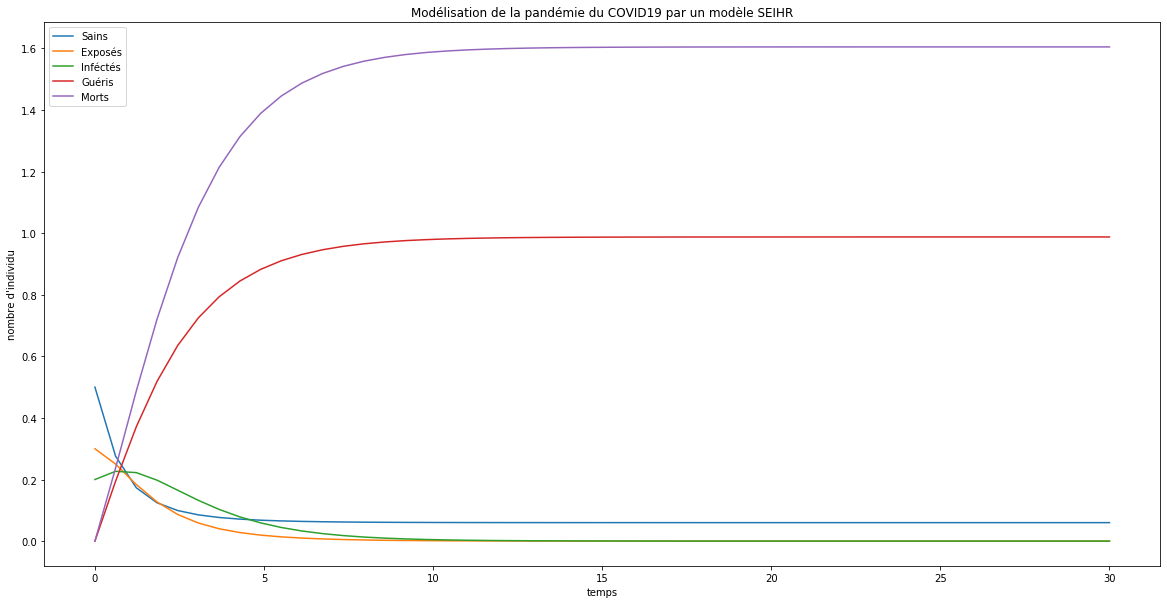

In [222]:
#Modélisation SIR 

def deriv(y, t, N,beta,alpha,lamb,gamma,mu):
    """
    y : liste contenant les 3 fonctions inconnus 
    t : le temps 
    beta, gamma : les deux facteurs du modèle
    """
    S,E,I,H,R = y 

  # Description des 3 equations differentielles 
    #dSdt = -S * I  * beta 
    #dIdt = S * I  * beta  - gamma * I 
    #dRdt = gamma * I 
    dSdt = - S * E* beta  
    dEdt =   beta * S * I -alpha*E -lamb*E 
    dIdt =   alpha* E -gamma*I 
    dHdt =   lamb*E + gamma*I 
    dRdt =   mu * I
    
    return dSdt, dEdt, dIdt, dHdt, dRdt 


# Au temps t0,  50% sains, 30% Exposé, 20% infecté, 0% Morts
y0 = 0.5, 0.3, 0.2, 0, 0 
t = np.linspace(0, 30)

# Paramètres du modèle 
v = 0.03      # taux de natalité en france
N = 67000000  # population initiale 46601
beta = 3.5    # taux de transmission 
alpha = 0.7   # taux d'incubation 
lamb = 0.6    # taux de guérison 
gamma =  0.7  # taux de gérison réel 
mu = 1.8      # taux de mortalité
epsilon = 0.035 # taux de rechute 


# Resolution des équations differentielles 
ret = odeint(deriv, y0, t, args = (N,beta,alpha,lamb,gamma,mu))
S,E,I,H,R = ret.T

plt.figure(figsize=(20,10))
plt.plot(t, S, label="Sains")
plt.plot(t, E,label="Exposés")
plt.plot(t, I, label="Inféctés")
plt.plot(t, H,label="Guéris")
plt.plot(t, R, label="Morts")

plt.xlabel("temps")
plt.ylabel("nombre d'individu")
plt.legend()
plt.title(f"Modélisation de la pandémie du COVID19 par un modèle SEIHR")

### Visualisation de l'impact des mesures sanitaires sur la pandémie


In [127]:
# séparer la BDD en deux dataset pendant et après confinement)
durant_conf = df.loc['2020-03-18':'2020-05-11']
apres_conf = df.loc['2020-05-12':'2020-08-31']

In [129]:
durant_conf.head(10)
apres_conf.head(10)

dep  sexe  hosp  rea  rad  dc
jour                                    
2020-03-18  01     0     2    0    1   0
2020-03-18  01     1     1    0    1   0
2020-03-18  01     2     1    0    0   0
2020-03-18  02     0    41   10   18  11
2020-03-18  02     1    19    4   11   6
2020-03-18  02     2    22    6    7   5
2020-03-18  03     0     4    0    1   0
2020-03-18  03     1     1    0    0   0
2020-03-18  03     2     3    0    1   0
2020-03-18  04     0     3    1    2   0

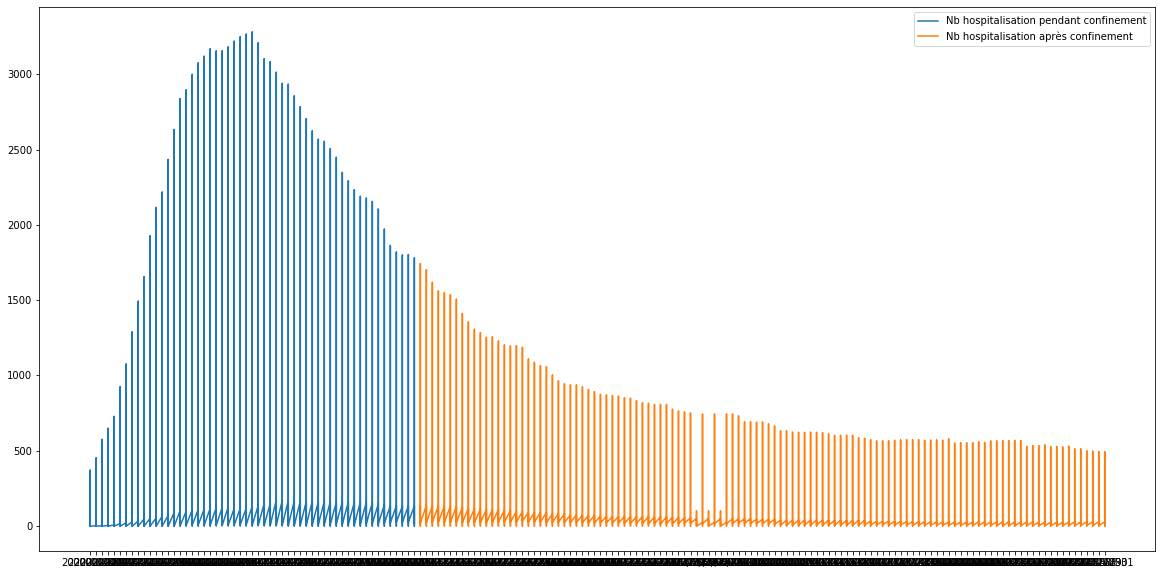

In [140]:
# Nombre d'hospitalisation pendant et apres le confinement
plt.figure(figsize=(20,10))
fig1 = plt.plot(durant_conf.index, durant_conf['hosp'], label="Nb hospitalisation pendant confinement")
fig2 = plt.plot(apres_conf.index, apres_conf['hosp'],   label="Nb hospitalisation après confinement")
plt.legend()
plt.show()


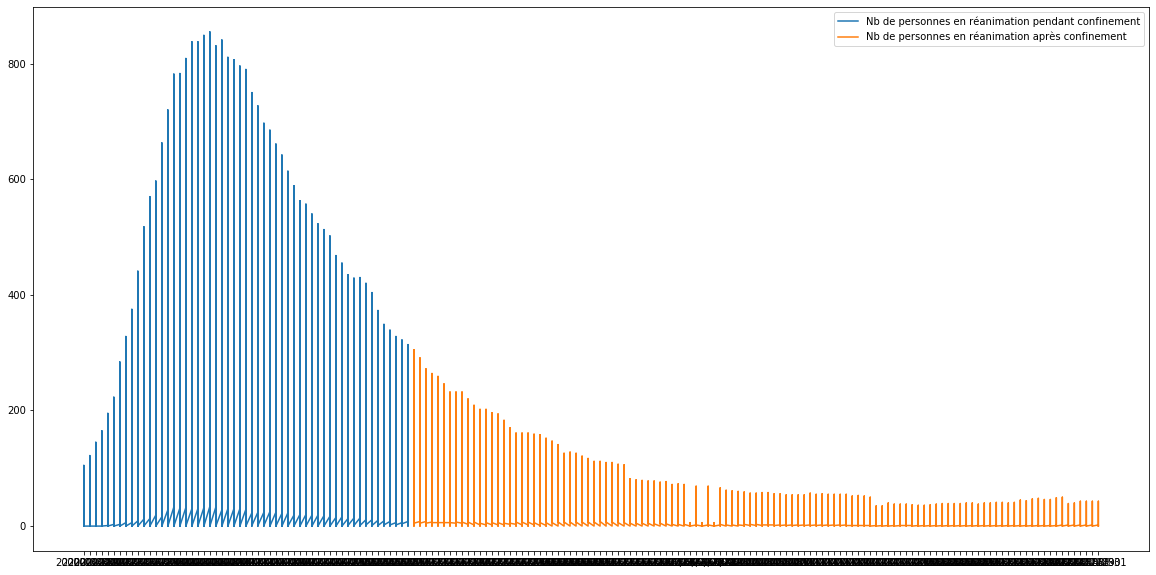

In [141]:
# Nombre d'hospitalisation pendant et apres le confinement
plt.figure(figsize=(20,10))
fig1 = plt.plot(durant_conf.index, durant_conf['rea'], label="Nb de personnes en réanimation pendant confinement")
fig2 = plt.plot(apres_conf.index, apres_conf['rea'],   label="Nb de personnes en réanimation après confinement")
plt.legend()
plt.show()

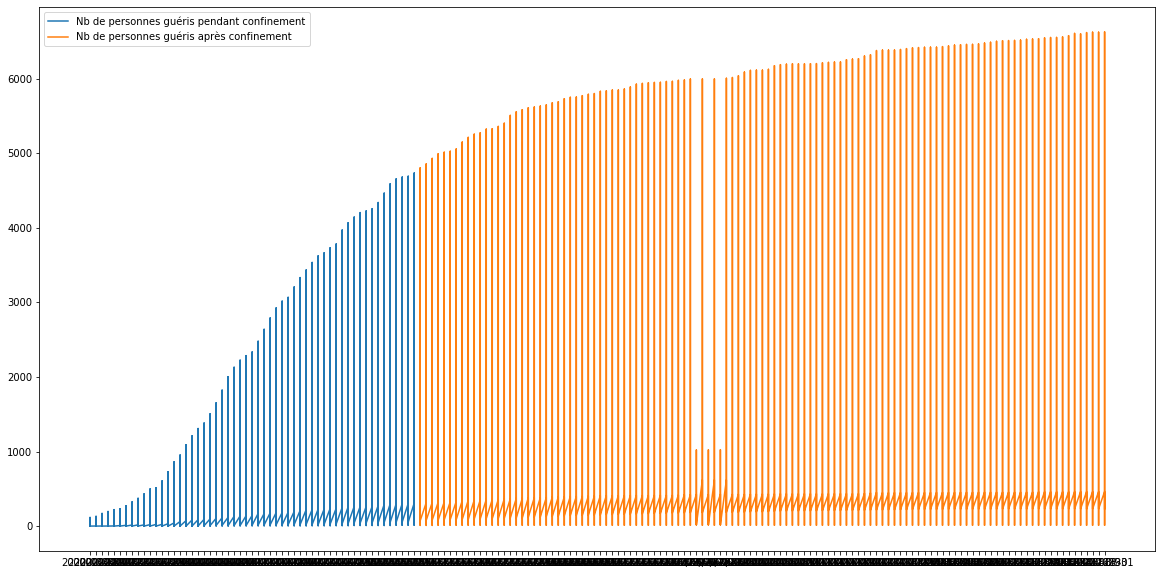

In [142]:
# Nombre d'hospitalisation pendant et apres le confinement
plt.figure(figsize=(20,10))
fig1 = plt.plot(durant_conf.index, durant_conf['rad'], label="Nb de personnes guéris pendant confinement")
fig2 = plt.plot(apres_conf.index, apres_conf['rad'],   label="Nb de personnes guéris après confinement")
plt.legend()
plt.show()

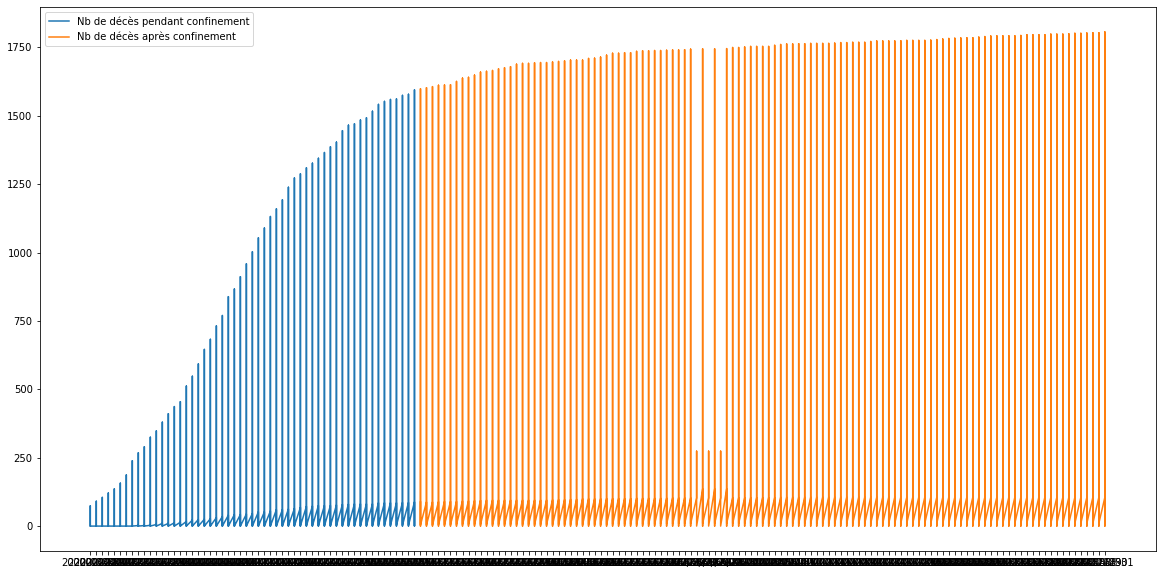

In [143]:
# Nombre d'hospitalisation pendant et apres le confinement
plt.figure(figsize=(20,10))
fig1 = plt.plot(durant_conf.index, durant_conf['dc'], label="Nb de décès pendant confinement")
fig2 = plt.plot(apres_conf.index, apres_conf['dc'],   label="Nb de décès après confinement")
plt.legend()
plt.show()

### Comparaison du nombre de décès avec les données mondiale de Google

In [169]:
# Les données seront consatemment mises à jour
df_RS = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv', sep=',', low_memory=False)
#df_RS = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', sep=',',low_memory=False)
df_RS.head(10)


region_code  region_name        date  cases_cumulative  cases_new  \
0         AFG  Afghanistan  2019-12-31               0.0        0.0   
1         AFG  Afghanistan  2020-01-01               0.0        0.0   
2         AFG  Afghanistan  2020-01-02               0.0        0.0   
3         AFG  Afghanistan  2020-01-03               0.0        0.0   
4         AFG  Afghanistan  2020-01-04               0.0        0.0   
5         AFG  Afghanistan  2020-01-05               0.0        0.0   
6         AFG  Afghanistan  2020-01-06               0.0        0.0   
7         AFG  Afghanistan  2020-01-07               0.0        0.0   
8         AFG  Afghanistan  2020-01-08               0.0        0.0   
9         AFG  Afghanistan  2020-01-09               0.0        0.0   

   cases_cumulative_per_million  cases_new_per_million  deaths_cumulative  \
0                           0.0                    0.0                0.0   
1                           0.0                    0.0                0.0   
2                           0.0                    0.0                0.0   
3                           0.0                    0.0                0.0   
4                           0.0                    0.0                0.0   
5                           0.0                    0.0                0.0   
6                           0.0                    0.0                0.0   
7                           0.0                    0.0                0.0   
8                           0.0                    0.0                0.0   
9                           0.0                    0.0                0.0   

   deaths_new  deaths_cumulative_per_million  ...  stringency_index  \
0         0.0                            0.0  ...               NaN   
1         0.0                            0.0  ...               0.0   
2         0.0                            0.0  ...               0.0   
3         0.0                            0.0  ...               0.0   
4         0.0                            0.0  ...               0.0   
5         0.0                            0.0  ...               0.0   
6         0.0                            0.0  ...               0.0   
7         0.0                            0.0  ...               0.0   
8         0.0                            0.0  ...               0.0   
9         0.0                            0.0  ...               0.0   

   stringency_index_for_display  stringency_legacy_index  \
0                           NaN                      NaN   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
5                           0.0                      0.0   
6                           0.0                      0.0   
7                           0.0                      0.0   
8                           0.0                      0.0   
9                           0.0                      0.0   

   stringency_legacy_index_for_display  government_response_index  \
0                                  NaN                        NaN   
1                                  0.0                        0.0   
2                                  0.0                        0.0   
3                                  0.0                        0.0   
4                                  0.0                        0.0   
5                                  0.0                        0.0   
6                                  0.0                        0.0   
7                                  0.0                        0.0   
8                                  0.0                        0.0   
9                                  0.0                        0.0   

  government_response_index_for_display  containment_health_index  \
0                                   NaN                       NaN   
1                              

In [170]:
# On récupère les données qui concerne la France
FR_df = df_RS[df_RS['region_code'] == 'FRA']
FR_df


region_code region_name        date  cases_cumulative  cases_new  \
15001         FRA      France  2019-12-31               0.0        0.0   
15002         FRA      France  2020-01-01               0.0        0.0   
15003         FRA      France  2020-01-02               0.0        0.0   
15004         FRA      France  2020-01-03               0.0        0.0   
15005         FRA      France  2020-01-04               0.0        0.0   
15006         FRA      France  2020-01-05               0.0        0.0   
15007         FRA      France  2020-01-06               0.0        0.0   
15008         FRA      France  2020-01-07               0.0        0.0   
15009         FRA      France  2020-01-08               0.0        0.0   
15010         FRA      France  2020-01-09               0.0        0.0   
15011         FRA      France  2020-01-10               0.0        0.0   
15012         FRA      France  2020-01-11               0.0        0.0   
15013         FRA      France  2020-01-12               0.0        0.0   
15014         FRA      France  2020-01-13               0.0        0.0   
15015         FRA      France  2020-01-14               0.0        0.0   
15016         FRA      France  2020-01-15               0.0        0.0   
15017         FRA      France  2020-01-16               0.0        0.0   
15018         FRA      France  2020-01-17               0.0        0.0   
15019         FRA      France  2020-01-18               0.0        0.0   
15020         FRA      France  2020-01-19               0.0        0.0   
15021         FRA      France  2020-01-20               0.0        0.0   
15022         FRA      France  2020-01-21               0.0        0.0   
15023         FRA      France  2020-01-22               0.0        0.0   
15024         FRA      France  2020-01-23               0.0        0.0   
15025         FRA      France  2020-01-24               0.0        0.0   
15026         FRA      France  2020-01-25               3.0        3.0   
15027         FRA      France  2020-01-26               3.0        0.0   
15028         FRA      France  2020-01-27               3.0        0.0   
15029         FRA      France  2020-01-28               3.0        0.0   
15030         FRA      France  2020-01-29               4.0        1.0   
...           ...         ...         ...               ...        ...   
15216         FRA      France  2020-08-02          187919.0        0.0   
15217         FRA      France  2020-08-03          187919.0        0.0   
15218         FRA      France  2020-08-04          191295.0     3376.0   
15219         FRA      France  2020-08-05          192334.0     1039.0   
15220         FRA      France  2020-08-06          194029.0     1695.0   
15221         FRA      France  2020-08-07          195633.0     1604.0   
15222         FRA      France  2020-08-08          197921.0     2288.0   
15223         FRA      France  2020-08-09          197921.0        0.0   
15224         FRA      France  2020-08-10          197921.0        0.0   
15225         FRA      France  2020-08-11          202775.0     4854.0   
15226         FRA      France  2020-08-12          204172.0     1397.0   
15227         FRA      France  2020-08-13          206696.0     2524.0   
15228         FRA      France  2020-08-14          209365.0     2669.0   
15229         FRA      France  2020-08-15          212211.0     2846.0   
15230         FRA      France  2020-08-16          215521.0     3310.0   
15231         FRA      France  2020-08-17          218536.0     3015.0   
15232         FRA      France  2020-08-18          219029.0      493.0   
15233         FRA      France  2020-08-19          221267.0     2238.0   
15234         FRA      France  2020-08-20          225043.0     3776.0   
15235         FRA      France  2020-08-21          229814.0     4771.0   
15236         FRA      France  2020-08-22          234400.0     4586.0   
15237         FRA      France  2020-08-23          238002.0     3602.0   
15238     

In [174]:
# On filtre les données
sub_FR_df = FR_df.filter(['deaths_cumulative','date'])
# mettre en indexe la date 
sub_FR_df.index = sub_FR_df['date'] 
sub_FR_df = sub_FR_df.drop(['date'], axis=1)
print(sub_FR_df)

            deaths_cumulative
date                         
2019-12-31                0.0
2020-01-01                0.0
2020-01-02                0.0
2020-01-03                0.0
2020-01-04                0.0
2020-01-05                0.0
2020-01-06                0.0
2020-01-07                0.0
2020-01-08                0.0
2020-01-09                0.0
2020-01-10                0.0
2020-01-11                0.0
2020-01-12                0.0
2020-01-13                0.0
2020-01-14                0.0
2020-01-15                0.0
2020-01-16                0.0
2020-01-17                0.0
2020-01-18                0.0
2020-01-19                0.0
2020-01-20                0.0
2020-01-21                0.0
2020-01-22                0.0
2020-01-23                0.0
2020-01-24                0.0
2020-01-25                0.0
2020-01-26                0.0
2020-01-27                0.0
2020-01-28                0.0
2020-01-29                0.0
...                       ...
2020-08-02

In [177]:
Google_df = sub_FR_df.loc['2020-03-18':'2020-08-31']
Google_df.head(10)

deaths_cumulative
date                         
2020-03-18              175.0
2020-03-19              244.0
2020-03-20              372.0
2020-03-21              450.0
2020-03-22              562.0
2020-03-23              674.0
2020-03-24              860.0
2020-03-25             1100.0
2020-03-26             1331.0
2020-03-27             1696.0

In [188]:
# récupérér les données du début du confinement jusqu'à aujourd'hui et calculé leur somme cumulé
SPF_df = df.loc['2020-03-18':'2020-08-31']['dc'].cumsum()
SPF_df

jour
2020-03-18          0
2020-03-18          0
2020-03-18          0
2020-03-18         11
2020-03-18         17
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         22
2020-03-18         24
2020-03-18         24
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
2020-03-18         26
               ...   
2020-08-31    5299097
2020-08-31    5299408
2020-08-31    5299649
2020-08-31    5300763
2020-08-31    5301410
2020-08-31    5301873
2020-08-31    5302895
2020-08-31    5303514
2020-08-31    5303913
2020-08-31    5305143
2020-08-31    5305854
2020-08-31    5306360
2020-08-31    5307090
2020-08-31    5307544
2020-

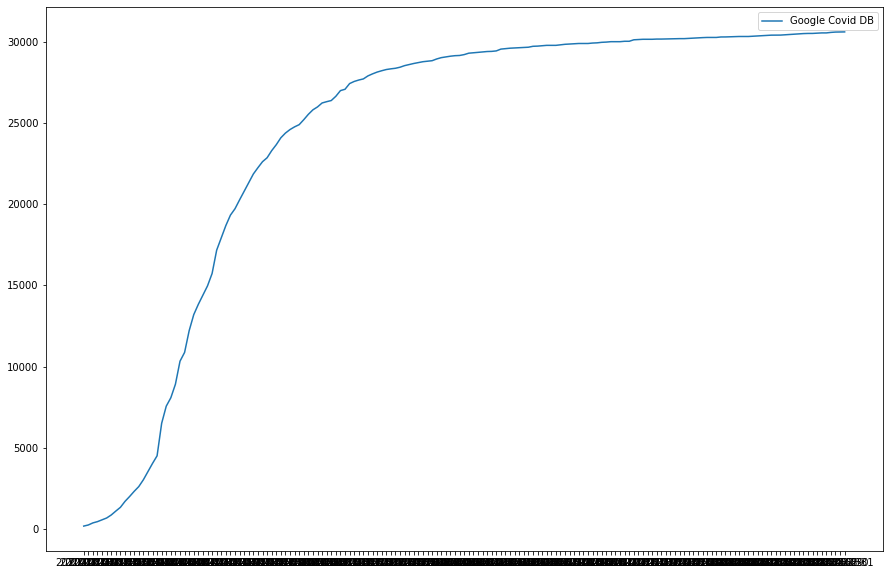

In [196]:
# Afficher le la somme cumulée des décès par Google
plt.figure(figsize=(15,10))
fig = plt.plot(Google_df.index, Google_df['deaths_cumulative'], label='Google Covid DB')
plt.legend()
plt.show()

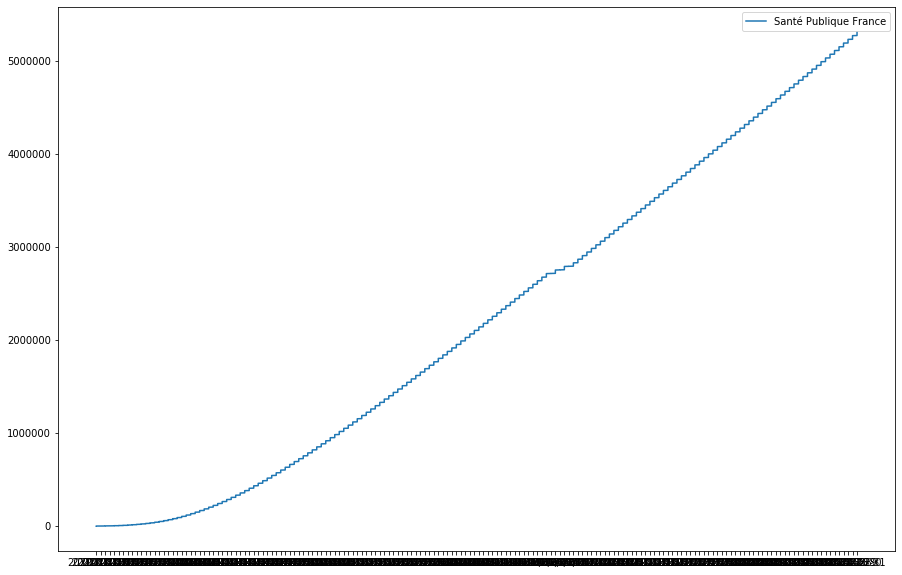

In [194]:
# Afficher le la somme cumulée des décès par Santé publique France
plt.figure(figsize=(15,10))
plt.plot(SPF_df, label='Santé Publique France')
plt.legend()
plt.show()